In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime

In [5]:
current_datetime =  datetime.now()
current_date_str = str(current_datetime.date()).replace('-','_')
output_directory = '../data/processed/'
output_filename = current_date_str + '_clean_player_data.csv'
file_path = output_directory + output_filename

df = pd.read_csv(file_path)


duplicate_players = df[df.duplicated(subset=['Player'], keep=False)]

duplicate_players_same_team = duplicate_players[duplicate_players.duplicated(subset=['Player', 'Team'], keep=False)]

df = df.drop_duplicates(subset=['Player', 'Team'], keep='first')



defense_df = df[df['Pos'] == 'D']

Lets take a look at our features and drop columns that will be irrelevant to our model

In [255]:
print(defense_df.columns)

Index(['Unnamed: 0', 'Player', 'Age', 'Pos', 'GP', 'G', 'A', 'PTS', '+/-',
       'PIM', 'EV', 'PP', 'SH', 'GW', 'EV.1', 'PP.1', 'SH.1', 'S', 'S%', 'TOI',
       'ATOI', 'OPS', 'DPS', 'PS', 'BLK', 'HIT', 'FOW', 'FOL', 'FO%', 'Ht',
       'Wt', 'S/C', 'Exp', 'Team', 'specific_pos', 'Cap%', 'Salary'],
      dtype='object')


In [256]:
def prep_atoi(atoi_string):
    list = atoi_string.split(':')
    minutes = int(list[0])
    seconds = int(list[1])

    return minutes + (seconds/60)

In [257]:
columns_to_drop = ['Unnamed: 0', 'Pos', 'EV.1', 'PP.1', 'SH.1', 'TOI','FOW', 'FOL', 'FO%',  'S/C','Team', 'specific_pos', 'Cap%', 'ATOI', 'Ht', 'Wt' ]

defense_df['clean_atoi'] = defense_df['ATOI'].apply(prep_atoi)

df = defense_df.drop(columns=columns_to_drop)
df = df.dropna()

/tmp/ipykernel_24004/2009094868.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defense_df['clean_atoi'] = defense_df['ATOI'].apply(prep_atoi)


Next I want to normalize some statistics to per game. 

In [258]:
df.columns

Index(['Player', 'Age', 'GP', 'G', 'A', 'PTS', '+/-', 'PIM', 'EV', 'PP', 'SH',
       'GW', 'S', 'S%', 'OPS', 'DPS', 'PS', 'BLK', 'HIT', 'Exp', 'Salary',
       'clean_atoi'],
      dtype='object')

In [259]:
df['GPG'] = df['G'] / df['GP']
df['APG'] = df['A'] / df['GP']
df['PIM_pergame'] = df['PIM'] / df['GP']
df['shots_per_game'] = df['S'] / df['GP']
df['shot%_per_game'] = df['S%'] / df['GP']
df['hits_per_game'] = df['HIT'] / df['GP']
df['blocks_per_game'] = df['BLK'] / df['GP']

 
df = df.drop(columns=['G', 'A', 'PIM', 'S', 'S%', 'HIT', 'BLK', 'GP', 'PTS'])

Feature Importance Ranking:
1. Feature 'clean_atoi': 0.41951138120807646
2. Feature 'Exp': 0.15662932499359988
3. Feature 'shots_per_game': 0.14311942225689647
4. Feature 'APG': 0.050887229361204926
5. Feature 'blocks_per_game': 0.035407813708179525
6. Feature '+/-': 0.031853677903765774
7. Feature 'PIM_pergame': 0.030781909759111402
8. Feature 'Age': 0.03028801231261731
9. Feature 'hits_per_game': 0.02249906481703985
10. Feature 'PS': 0.02162729432041917
11. Feature 'DPS': 0.018555763250431852
12. Feature 'OPS': 0.009386605941520475
13. Feature 'shot%_per_game': 0.008768826392876523
14. Feature 'GPG': 0.007975950118928146
15. Feature 'GW': 0.0044904700502999126
16. Feature 'PP': 0.004216279483445986
17. Feature 'EV': 0.003343435890338946
18. Feature 'SH': 0.0006575382312474328


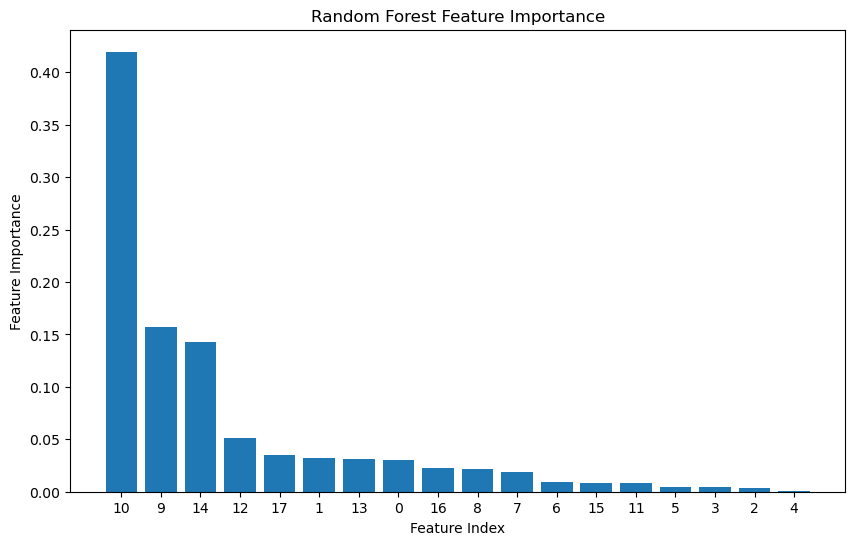

In [260]:
player_names = df['Player']


# Features (X) - Exclude the target column
X = df.drop(['Salary', 'Player'], axis=1)

# Target (y) - The column you want to predict
y = df['Salary']


pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

X_encoded = pd.get_dummies(X)


# Split the data into training and testing sets
# Adjust the test_size parameter as needed
X_train, X_test, y_train, y_test, player_names_train, player_names_test = train_test_split(
    X_encoded, y, player_names, test_size=0.2, random_state=42
)

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor()

# Fit the model to your training data
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Get the indices of features sorted by importance
sorted_indices = np.argsort(feature_importances)[::-1]



# Print feature importance ranking with original column names
print("Feature Importance Ranking:")

ordered_feature_importance = []

for i, index in enumerate(sorted_indices):
    original_column_name = X_encoded.columns[index]
    ordered_feature_importance.append(original_column_name)
    print(f"{i + 1}. Feature '{original_column_name}': {feature_importances[index]}")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importances[sorted_indices], align="center")
plt.xticks(range(X_train.shape[1]), sorted_indices)
plt.xlabel("Feature Index")
plt.ylabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()


In [261]:
print(ordered_feature_importance[:7])

['clean_atoi', 'Exp', 'shots_per_game', 'APG', 'blocks_per_game', '+/-', 'PIM_pergame']


In [262]:
important_features = ['Player','Salary'] + ordered_feature_importance[:7] 


final_dataset = df[important_features]

Mean Squared Error: 2605831837590.8955
R-squared: 0.5867186267358183


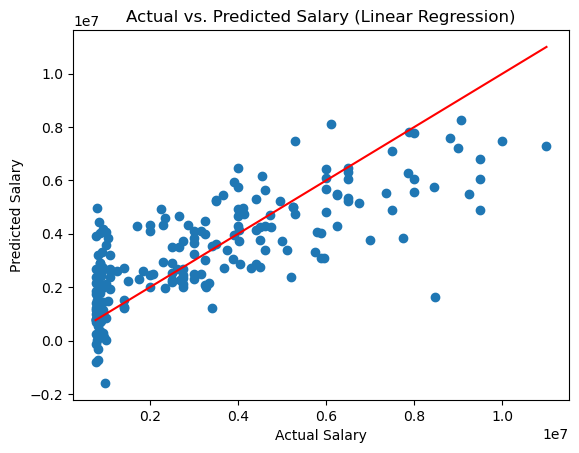

In [263]:
player_names = final_dataset['Player']

X = final_dataset.drop(['Salary', 'Player'], axis=1)

# Target (y) - The column you want to predict
y = final_dataset['Salary']

X_encoded = pd.get_dummies(X)


X_train, X_test, y_train, y_test, player_names_train, player_names_test = train_test_split(
    X_encoded, y, player_names, test_size=0.2, random_state=42
)


linear_model = LinearRegression()

linear_model.fit(X_train, y_train)

predictions_linear = linear_model.predict(X)


results_df = pd.DataFrame({'Player': player_names, 'Actual_Salary': y, 'Predicted_Salary': predictions_linear})




# Evaluate the model
mse = mean_squared_error(y, predictions_linear)
r2 = r2_score(y, predictions_linear)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Plotting actual vs. predicted values
plt.scatter(y, predictions_linear)

plotting_values = np.linspace(np.min(y), np.max(y), 1000)
plt.plot(plotting_values, plotting_values, color='r')
plt.plot()
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs. Predicted Salary (Linear Regression)")
plt.show()


Random Forest Model:
Mean Squared Error: 912099216464.9261
R-squared: 0.8553423090101223


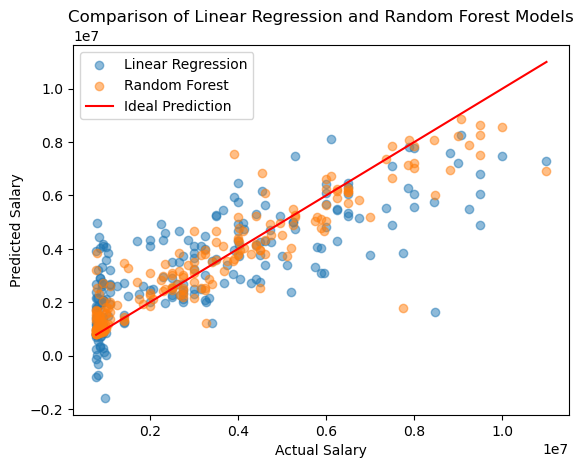

In [264]:
# Random Forest Model
random_forest_model = RandomForestRegressor(random_state=42)
random_forest_model.fit(X_train, y_train)
predictions_rf = random_forest_model.predict(X_encoded)

# Evaluate Random Forest model
mse_rf = mean_squared_error(y, predictions_rf)
r2_rf = r2_score(y, predictions_rf)

print("\nRandom Forest Model:")
print("Mean Squared Error:", mse_rf)
print("R-squared:", r2_rf)

# Compare the models visually
plt.scatter(y, predictions_linear, label='Linear Regression', alpha=0.5)
plt.scatter(y, predictions_rf, label='Random Forest', alpha=0.5)

plt.plot(np.linspace(np.min(y_test), np.max(y_test), 100), np.linspace(np.min(y_test), np.max(y_test), 100), color='r', label='Ideal Prediction')

plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Comparison of Linear Regression and Random Forest Models")
plt.legend()
plt.show()

In [265]:
results_df = pd.DataFrame({'Player': player_names, 'Actual_Salary': y, 'Predicted_Salary': predictions_rf})
results_df['difference'] = results_df['Actual_Salary'] - results_df['Predicted_Salary']
results_df['Actual_Salary'] = results_df['Actual_Salary'].apply(lambda x: "{:e}".format(x))


overpaid_df = results_df[results_df['difference'] > 0]
underpaid_df = results_df[results_df['difference'] < 0]


In [266]:
print(f'There are {results_df.shape[0]} defensemen in the dataset and {overpaid_df.shape[0]} are overpaid, and {underpaid_df.shape[0]} are underpaid')

There are 207 defensemen in the dataset and 77 are overpaid, and 130 are underpaid


In [267]:
overpaid_df.sort_values(by='difference', ascending=False).head(20)

,Player,Actual_Salary,Predicted_Salary,difference
56,Dmitry Orlov,7.750000e+06,1782458.33,5967541.67
579,Drew Doughty,1.100000e+07,6907750.00,4092250.00
43,Sebastian Aho,8.460250e+06,6003313.31,2456936.69
478,Marco Scandella,3.275000e+06,1227352.50,2047647.50
4,Adam Fox,9.500000e+06,7498488.58,2001511.42
430,Tyson Barrie,4.500000e+06,2537341.66,1962658.34
555,Alex Pietrangelo,8.800000e+06,6959473.33,1840526.67
699,Marc-Edouard Vlasic,7.000000e+06,5179595.83,1820404.17
70,Erik Karlsson,1.000000e+07,8580405.00,1419595.00
602,Darnell Nurse,9.250000e+06,7874251.77,1375748.23


In [268]:
underpaid_df.sort_values(by='difference', ascending=True).head(20)

,Player,Actual_Salary,Predicted_Salary,difference
596,Evan Bouchard,3.900000e+06,7546030.00,-3646030.00
235,Mark Giordano,8.000000e+05,3833624.99,-3033624.99
387,Jack Johnson,7.750000e+05,3192750.00,-2417750.00
621,Rasmus Andersson,4.550000e+06,6853183.33,-2303183.33
231,Timothy Liljegren,1.400000e+06,3469169.28,-2069169.28
335,Jake Sanderson,9.250000e+05,2698828.41,-1773828.41
411,Jani Hakanpaa,1.500000e+06,3268769.64,-1768769.64
459,Travis Dermott,8.000000e+05,2523906.64,-1723906.64
362,Dylan DeMelo,3.000000e+06,4677105.18,-1677105.18
344,Travis Hamonic,1.100000e+06,2599758.33,-1499758.33
